这个算法首先使用meanshift，meanshift找到目标之后，再去调整窗口的大小，他还会计算目标对象的最佳外接椭圆的角度，并以此调节窗口角度。然后使用更新后的窗口大小和角度来在原来的位置继续进行meanshift，重复这个过程知道达到所需精度。

### 优点

能够自动调节搜索窗口大小来适应目标的大小，可以跟踪视频中尺寸变化的目标。它也是一种半自动跟踪算法，需要手动标定跟踪目标。基本思想是以视频图像中运动物体的颜色信息作为特征，对输入图像的每一帧分别作 Mean-Shift 运算，并将上一帧的目标中心和搜索窗口大小(核函数带宽)作为下一帧 Mean shift 算法的中心和搜索窗口大小的初始值，如此迭代下去，就可以实现对目标的跟踪。因为在每次搜索前将搜索窗口的位置和大小设置为运动目标当前中心的位置和大小，而运动目标通常在这区域附近，缩短了搜索时间；另外，在目标运动过程中，颜色变化不大，故该算法具有良好的鲁棒性。已被广泛应用到运动人体跟踪，人脸跟踪等领域.

### 缺点

CamShfit 算法在计算目标模板直方图分布时，没有使用核函数进行加权处理，也就是说目标区域内的每个像素点在目标模型中有着相同的权重，故 CamShfit 算法的抗噪能力低于Mean-Shift跟踪算法。另一方面，CamShift 算法中没有定义候选目标，直接利用目标模板进行跟踪。除此以外，CamShift 算法采用 HSV 色彩空间的H分量建立目标直方图模型，仍然只是依据目标的色彩信息来进行跟踪，当目标与背景颜色接近或者被其他物体遮挡时，CamShift 会自动将其包括在内，导致跟踪窗口扩大，有时甚至会将跟踪窗口扩大到整个视频大小，导致目标定位的不准确，连续跟踪下去造成目标的丢失。

### 参考文献

[reference](https://blog.csdn.net/qq_37791134/java/article/details/81003626)

使用方法和meanshift基本一样，但是返回的结果是一个带旋转角度的矩形，以及这个矩形的参数。

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [5]:
def cv2_imread(img_path, flag=None):
    if flag is None or flag > 0:
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif flag == 0:
        img = cv2.imread(str(img_path), flag)
    else:
        msg = 'unknow flag code: {}'.format(flag)
        raise ValueError(msg)
    return img

def display_img(img, cmap=None):
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot()
    if cmap is None or cmap == 'plamsa':
        ax.imshow(img)
    else:
        ax.imshow(img, cmap=cmap)
    ax.set_title(f'shape: {img.shape}')
    ax.axis('on')
    plt.show()
    
def plot_rectangle(img, box):
    # box: [xmin, ymin, xmax, ymax]
    fig, ax = plt.subplots(figsize=[16, 10])
    rect = Rectangle(xy=[box[0], box[1]], 
                         width=box[2]-box[0], 
                         height=box[-1]-box[1], 
                         fill = None, 
                         edgecolor='r')
    ax.add_patch(rect)
    ax.imshow(img)
    plt.show()

`cv2.boxPoints(box[, points])`

+ 

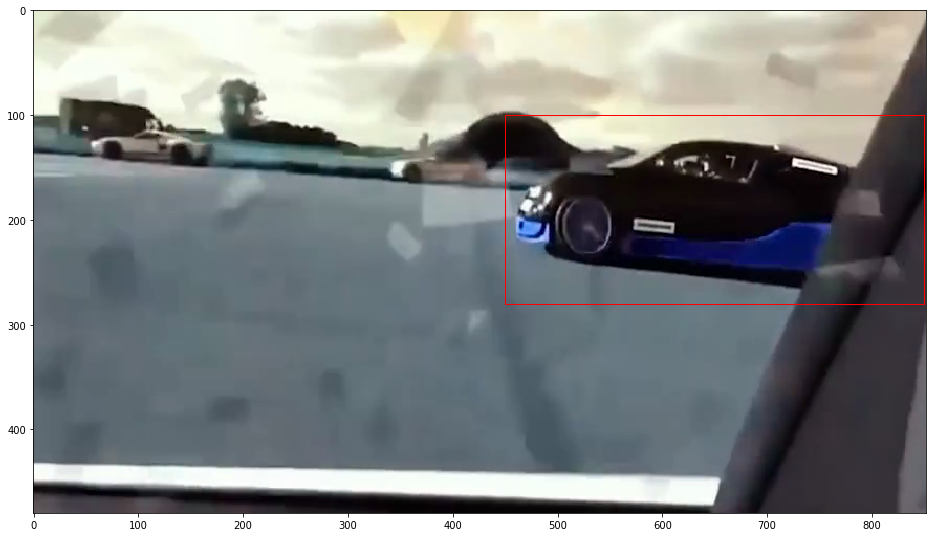

In [6]:
video = cv2.VideoCapture('./imgdata/car.flv')

# 设置起始帧
video.set(cv2.CAP_PROP_POS_FRAMES, 300)
flag, frame = video.read()

# 选取roi的范围很重要，roi部分要包括要追踪的目标但不能包含过多非目标内容
xmin, ymin, xmax, ymax = 450, 100, 850, 280
track_window = (xmin, ymin, xmax-xmin, ymax-ymin)

roi = frame[ymin:ymax, xmin:xmax]
plot_rectangle(frame, [xmin, ymin, xmax, ymax])
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# 将亮度过高和过低的值忽略掉
mask = cv2.inRange(hsv_roi, np.array((20, 20, 20)), np.array((180, 255, 46)))

roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

# 确定窗口搜索停止的准则，迭代次数达到设置的最大值，或者窗口中心的漂移值小于设定值
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)
mark = 1

for _ in range(465-300):
    ret, frame = video.read()
    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # 直方图反向投影
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)
        
        # ret表示一个带有旋转角度的矩形
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)
        
        # cv2.boxPoints()将ret代表的矩形转换为box的四个顶点坐标
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv2.polylines(frame, pts=[pts], isClosed=True, color=255, thickness=2)
        cv2.imwrite(f'./camshift/img_{mark}.jpg', img2)
        mark += 1

步骤一：计算目标区域内的颜色直方图。
  通常是将输入图像转换到HSV颜色空间，目标区域为初始设定的搜索窗口范围，分离出色调H分量做该区域的色调直方图计算。因为 RGB 颜色空间对光线条件的改变较为敏感，要减小该因素对跟踪效果的影响，CamShift 算法通常采用 HSV 色彩空间进行处理，当然也可以用其它颜色空间计算。这样即得到目标模板的颜色直方图。
  
步骤二：根据获得的颜色直方图将原始输入图像转化成颜色概率分布图像，
  该过程称为“反向投影"。所谓直方图反向投影，就是输入图像在已知目标颜色直方图的条件下的颜色概率密度分布图，包含了目标在当前帧中的相干信息。对于输入图像中的每一个像素，查询目标模型颜色直方图，对于目标区域内的像素，可得到该像素属于目标像素的概率，而对于非目标区域内的像素,该概率为0。

步骤三：Mean Shift迭代过程。
目的在于找到目标中心在当前帧中的位置。首先在颜色概率分布图中选择搜索窗口的大小和初始位置，然后计算搜索窗口的质心位置。